# E3. 고양이 수염 스티커 만들기

- exploration 3 예제로는, 얼굴 영역을 찾아서 얼굴의 위에 왕관을 씌우는 연습을 해봤습니다.
- 실습으로는, 여러 가지 얼굴 사진을 불러오고 얼굴 영역을 찾아서 고양이 수염을 붙이는 과제를 해보려고 합니다.

### 실습 진행 목차
    
[1. 불러온 사진에서 얼굴 영역을 찾아보자](#1)   
[2. 얼굴 영역에서 Face Landmark를 찾아보자](#2)    
[3. 고양이 스티커를 얼굴 영역에 붙여보자(고양이 수염이 볼 위치에 가도록 붙인다)](#3)   
 &emsp;3-1) 코 위치에 스티커 붙이기   
    &emsp;3-2) 볼 위치에 스티커 붙이기   
    &emsp;3-3) 다양한 사진에 스티커 붙이기     
[4. 회고](#4)


### 실습 개요
- 이번 실습에서는 Dlib 패키지를 사용하여 "object detection을 활용한 face detector", "이목구비의 위치를 추론하는 face localization 기술"을 구현해봅니다. 그리고 다양한 이미지에서 얼굴을 찾아내고 원하는 위치에 스티커를 붙여봅니다.
- 실습에서 사용한 패키지들로 opencv, dlib이 있습니다.
   - opencv는 실시간 이미지 프로세싱에 중점을 둔 라이브러리입니다. (주의: python에서 이미지를 rgb가 아닌 bgr로 읽는다.)
   - dlib의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾습니다.
        
### Insight
- 실생활에서 얼굴인식을 활용하는 예시로는, Facebook에 사진을 올릴 때 얼굴을 인식하고 자동으로 태그를 달아주는 기능, snow 등 사진앱에서 얼굴에 실시간으로 필터를 씌워주는 기능 등이 있습니다. 관련해서 기사들을 찾아보며, 오늘 실습할 얼굴인식 기술이 상용화되고 있는 현황을 정리합니다.
    - “글로벌 IT 기업들과 대학의 천재 연구자들이 개발한 **인공지능을 사람들은 셀카 찍는데 주로 쓰고 있다**”(2017년, 동아사이언스, https://m.dongascience.com/news.php?idx=19180) 2017년에 이런 말을 기사에 실을만큼 우리 실생활에서 object detection은 스노우, 스냅챗 등의 뷰티필터에 자주 이용되고 있습니다.
    - MIT Technology Review 에서는 각종 SNS 셀피의 뷰티필터가 현실을 왜곡하며 사용자들에게 위험을 불러올 수 있다는 글을 확인할 수 있었습니다. 아직 이 논란에 대한 확실한 근거는 밝혀지지 않았지만, 주의를 기울여 인공지능 기술을 적용해야 함을 알 수 있습니다. 덧붙이면, 스탠포드 대학의 Virtual Human Interaction Lab 창립이사 제러미 베일런슨은 실시간 강아지 필터는 **"기술적으로 어려운 일"이라며 놀라움을 금치 않습니다. "신경망(neural networks) 덕분에 이제 인공지능은 실시간 비디오 변경(real-time video altering)에 필요한 데이터 처리를 고도화하는 데 도움을 주고 있다."** (2021년, https://www.technologyreview.kr/beauty-filters-young-girls-augmented-reality-social-media/)
    - 아래는 비현실적인 외모와 깨끗한 피부로 필터를 씌운 것이 아니냐 의심을 받고 있는 kpop그룹 매드몬스터. 이들의 얼굴이 화면에서 일그러지기도 해 악귀가 씌였다는 말도 돌고 있다. 각종 논란이 만연한데, 얼굴인식기술을 활용해서 활동중이라면 인공지능 기술을 키치하게 이용한 경우로 주목할만하다.

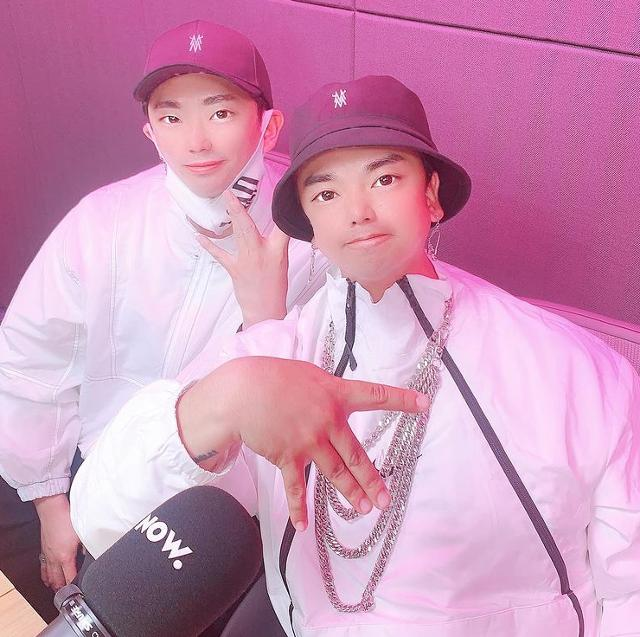

In [1]:
from IPython.display import Image
Image(filename='mad_monster.png', width = 400, height = 400) 

<a id='1'></a>

## 1. 불러온 사진에서 얼굴 영역 찾기

- 사진에서 사람 얼굴을 찾아줍니다. 이때, dlib의 HOG(Histogram of Oriented Gradient)를 사용해서 얼굴 영역을 사각형으로 찾아줍니다.
- HOG 기법은 단일 픽셀이 주변 픽셀들과 비교해서 이미지가 어두워지는 방향으로 화살표를 그립니다. 이미지의 모든 픽셀이 화살표로 바뀌는데, 화살표들을 그래디언트라고 부릅니다. 그리고 16x16 픽셀의 정사각형들에 대해 주요 특징이 드러나도록 표현해주며 훈련 얼굴이미지로부터 추출한 HOG패턴과 유사한 것을 얼굴 영역으로 detect합니다.

In [2]:
# 필요한 모듈을 가져옵니다.

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

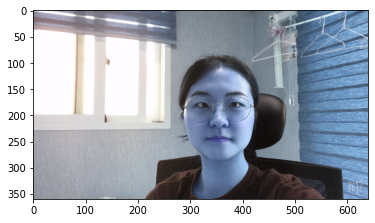

In [3]:
# 이미지 데이터를 준비합니다.
# 먼저 제 사진을 가져옵니다.

my_img_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/minji.png'
img_bgr = cv2.imread(my_img_path)
img_bgr = cv2.resize(img_bgr, (640,360))    # 640*360(16:9) 크기로 resize 합니다.

img_show = img_bgr.copy()    # 출력용 이미지를 별도로 만들어둡니다.
img_bgr2 = img_bgr.copy()    # 다양한 실험을 해볼 이미지를 복사해둡니다.
img_bgr3 = img_bgr.copy()

plt.imshow(img_bgr)   # opencv는 이미지를 bgr로 읽기 때문에 색이 조금 이상합니다.
plt.show()

In [4]:
# face detection: dlib의 hog detector로 얼굴 영역을 찾아줍니다.

detector_hog = dlib.get_frontal_face_detector()   # dlib을 활용해 detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # openCV의 bgr 이미지를 rgb로 변환
dlib_rects = detector_hog(img_rgb, 1)   # dlib detector는 dlib.rectangles 타입의 객체 반환

rectangles[[(270, 133) (425, 288)]]


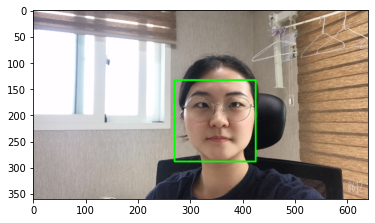

In [5]:
# 찾은 얼굴영역의 좌표를 활용해 초록 박스로 나타냅니다.

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

<a id='2'></a>

## 2. Face landmark 찾기
- Dlib에서 제공하는 ibug 300w 데이터셋으로 68개의 face landmark를 찾아줍니다.
- face landmark는 얼굴의 특징인 눈, 코, 입 등을 포착합니다.

In [6]:
# Dlib의 face landmark 모델을 불러옵니다.

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
# dlib의 모델을 활용해서 face landmark 좌표를 리스트로 만들어줍니다.

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print("face landmark 좌표의 개수: ", len(list_landmarks[0]))

face landmark 좌표의 개수:  68


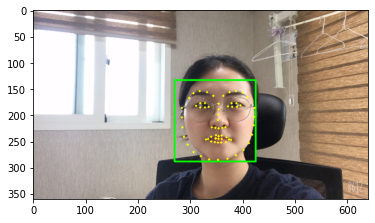

In [8]:
# list_landmarks 에서 좌표를 하나하나 가져와서 노란색 점을 찍어줍니다.

for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

<a id='3'></a>

## 3. 고양이 수염 사진 붙이기
- 스티커를 적용하는 위치를 다양하게 해보고, 다양한 구도의 사진에 스티커를 붙여보았습니다.    
  3-1) 고양이 코를 코 중심 landmark 좌표에 적용되게 하기      
  3-2) 고양이 수염이 적용될 볼 위치를 landmark로 활용하기     
  3-3) 다양한 구도의 사진에 스티커를 붙이기    

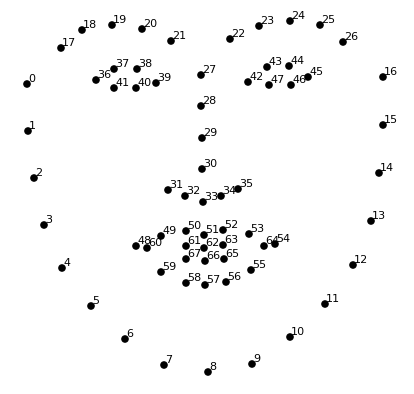

In [9]:
from IPython.display import Image
Image(filename='landmark.png', width = 400, height = 400) 

### 3-1) 코를 landmark로 하기

In [10]:
# 스티커를 붙이기 위해 필요한 좌표, 너비, 높이를 계산합니다.
# 스티커는 코 중심에 고양이의 코(스티커의 중심)가 오도록 그려봅니다.
# 고양이 코의 위치는 x = x(nose), y = y(nose), 스티커 크기는 width = height

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print('얼굴에서 코의 위치: ', landmark[30])
    
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print('코의 위치 좌표 (x,y) : (%d,%d)'%(x,y))
    print('스티커의 너비와 높이 (w,h) : (%d,%d)'%(w,h))    

얼굴에서 코의 위치:  (353, 209)
코의 위치 좌표 (x,y) : (353,209)
스티커의 너비와 높이 (w,h) : (156,156)


In [11]:
# 얼굴에 붙일 스티커 사진을 가져옵니다.
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)  # openCV 로 이미지 읽기
img_sticker = cv2.resize(img_sticker, (w,h))  # 위에서 정해준 너비와 높이로 resize
print("스티커 이미지의 크기:", img_sticker.shape)

스티커 이미지의 크기: (156, 156, 3)


In [12]:
# 스티커는 (156,156) 사이즈이고, 가운데를 코 중심에 붙여주면 됩니다.
# 코의 좌표에서 왼쪽, 위로 움직여서 스티커 이미지의 시작점인 왼쪽-위 좌표를 찾아줍니다.

refined_x = x - w // 2   # 코의 x좌표를 왼쪽으로 움직인다.
refined_y = y - h // 2   # 코의 y좌표를 위쪽으로 움직인다.
print('스티커 이미지의 시작점 (x,y) : (%d,%d)'%(refined_x,refined_y))

스티커 이미지의 시작점 (x,y) : (275,131)


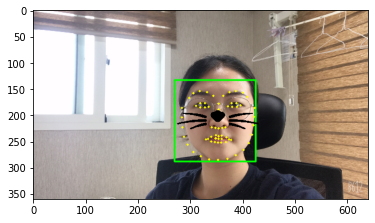

In [13]:
# 얼굴에 스티커를 적용합니다.
# 스티커는 검은 영역이 0으로 설정되어 있으므로, 스티커가 0인 부분에는 스티커를 표시하고, 아닌 부분에는 표시하지 않는다.

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

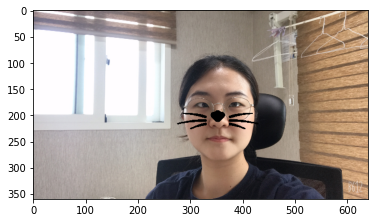

In [14]:
# 초록색 박스와 노란 점이 없는 깨끗한 원본 이미지에 스티커를 붙여줍니다.
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 3-2) 볼 위치를 landmark로 하기

In [15]:
# 스티커를 붙이기 위해 필요한 좌표, 너비, 높이를 계산합니다.
# 볼 위치에 고양이 수염이 적용되도록 합니다.

# 고양이 수염의 위치는 x = x(cheek) + {x(nose)-x(cheek)}//2,
# y = y(cheek) + {y(eye) - y(mouth)}//2,
# 스티커 크기는 width = height

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print('턱의 좌표:\n', landmark[2])
    x = landmark[2][0] + (landmark[30][0] - landmark[2][0]) // 2    # 볼은 코와 턱 사이에 있다.
    y = landmark[2][1] + (landmark[36][1] - landmark[48][1]) // 2   # 볼은 눈과 입 사이에 있다.
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('볼의 x좌표는 코와 턱 중간, y좌표는 눈과 얼굴 좌표의 중간\n (x,y) : (%d,%d)'%(x,y))
    print('스티커 너비와 높이는 구해준 정사각형 얼굴영역의 한변 길이\n (w,h) : (%d,%d)'%(w,h))    

턱의 좌표:
 (285, 223)
볼의 x좌표는 코와 턱 중간, y좌표는 눈과 얼굴 좌표의 중간
 (x,y) : (319,191)
스티커 너비와 높이는 구해준 정사각형 얼굴영역의 한변 길이
 (w,h) : (156,156)


In [16]:
# 스티커는 (156,156) 사이즈이고, 수염을 볼에 붙이면 됩니다.
# 스티커 이미지의 시작점인 왼쪽-위 좌표를 찾아줍니다. 볼에서 왼쪽, 위쪽으로 움직여줘야 합니다.
refined_x = x - w // 4   # 왼쪽
refined_y = y - h // 3   # 위
print('아까 구해준 x,y 좌표를 이미지의 시작점인 왼쪽-위 좌표로 변경해준다.\n', 
      '(x,y) : (%d,%d)'%(refined_x,refined_y))

아까 구해준 x,y 좌표를 이미지의 시작점인 왼쪽-위 좌표로 변경해준다.
 (x,y) : (280,139)


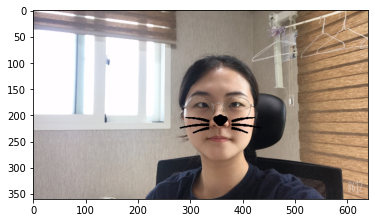

In [17]:
# 원본 이미지의 복사본 img_bgr2에 스티커를 적용합니다.
sticker_area = img_bgr2[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr2[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

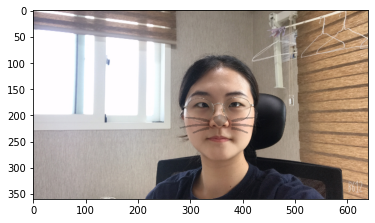

In [18]:
# 스티커 뒤로 배경 보이게 하기
# opencv의 addWeighted를 활용해서 원본 이미지와 스티커를 붙인 이미지를 선형적으로 결합해줍니다.
# 결합 비율을 적절하게 조정해주면 이미지 뒤로 배경이 보일 수 있습니다.

dst = cv2.addWeighted(img_bgr3, 0.7, img_bgr2, 0.3, 0.0)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()

**<opencv 이미지 블렌딩>**
1. addWeighted
    - cv2.addWeighted 함수의 인자가 (imgA, a, imgB,b, c)라고 한다면 산술식은 다음과 같습니다.    
      result = imgA * a + imgB * b + c
2. bitwise_and
    - 이 연산에서는 mask 를 만들어서 하나의 이미지 배경에 다른 이미지를 넣어줄 수 있습니다.

### 3-3) 다양한 사진에 스티커 붙이기 1번

* 기울어진 얼굴에 스티커 붙이기
* 얼굴이 기울어진 각도에 따라 스티커도 기울여서 붙여줘야 합니다. 이 부분의 구현에 대해 고민해보았습니다.

In [19]:
# 이미지 데이터를 준비합니다.
my_img_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_1.png'
img_bgr = cv2.imread(my_img_path)
img_bgr = cv2.resize(img_bgr, (640,360))    # 640*360(16:9) 크기로 resize 합니다.
img_show = img_bgr.copy()    # 출력용 이미지를 별도로 만들어둡니다.
img_bgr2 = img_bgr.copy()

In [20]:
# face detection: 얼굴 영역을 찾아줍니다.
detector_hog = dlib.get_frontal_face_detector()   # dlib을 활용해 detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # openCV의 bgr 이미지를 rgb로 변환
dlib_rects = detector_hog(img_rgb, 1)   # dlib detector는 dlib.rectangles 타입의 객체 반환

rectangles[[(239, 96) (368, 225)]]


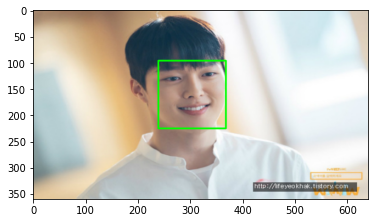

In [21]:
# 찾은 얼굴영역의 좌표를 활용해 초록 박스로 나타냅니다.

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [22]:
# dlib의 모델을 활용해서 face landmark 좌표를 리스트로 만들어줍니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print("face landmark 점의 개수는: ", len(list_landmarks[0]))

face landmark 점의 개수는:  68


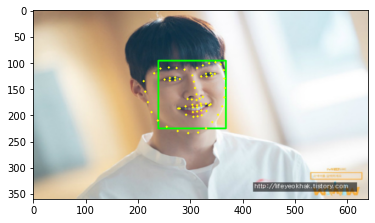

2번째 점의 좌표는 (219, 175)
30번째 점의 좌표는 (312, 160)
36번째 점의 좌표는 (251, 132)
48번째 점의 좌표는 (277, 187)


In [23]:
# list_landmarks 에서 좌표를 하나하나 가져와서 점을 찍어줍니다.

for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 필요한 landmark 점의 좌표를 확인합니다.
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        if idx == 2 or idx == 30 or idx == 48 or idx==36:
            print("{}번째 점의 좌표는 ({}, {})".format(idx, point[0], point[1]))
        else: continue

In [24]:
# 스티커를 붙이기 위해 필요한 좌표, 너비, 높이를 계산합니다.
# 볼 위치에 고양이 수염이 적용되도록 합니다.

# 고양이 수염의 위치는 x = x(cheek) + {x(nose)-x(cheek)}//2,
# y = y(cheek) + {y(eye) - y(mouth)}//2,
# 스티커 크기는 width = height

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print('턱의 좌표:\n',landmark[2])
    
    x = landmark[2][0] + (landmark[30][0] - landmark[2][0]) // 2
    y = landmark[2][1] + (landmark[36][1] - landmark[48][1]) // 2
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print('볼의 x좌표는 코와 턱 중간, y좌표는 눈과 얼굴 좌표의 중간\n (x,y) : (%d,%d)'%(x,y))
    print('스티커 너비와 높이는 구해준 정사각형 얼굴영역의 한변 길이\n (w,h) : (%d,%d)'%(w,h))    

턱의 좌표:
 (219, 175)
볼의 x좌표는 코와 턱 중간, y좌표는 눈과 얼굴 좌표의 중간
 (x,y) : (265,147)
스티커 너비와 높이는 구해준 정사각형 얼굴영역의 한변 길이
 (w,h) : (130,130)


스티커사진의 모양: (130, 130, 3)


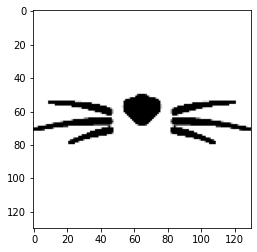

In [25]:
# 스티커 사진을 가져옵니다.
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)  # openCV 로 이미지 읽기
img_sticker = cv2.resize(img_sticker, (w,h))  # 위에서 정해준 너비와 높이로 resize

print('스티커사진의 모양:', img_sticker.shape)
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
# 스티커는 (156,156) 사이즈이고, 수염을 볼에 붙이면 됩니다.
# 스티커 이미지의 시작점인 왼쪽-위 좌표를 찾아줍니다. 볼에서 왼쪽, 위쪽으로 움직여줘야 합니다.

refined_x = x - w // 6   # x좌표를 왼쪽으로 이동
refined_y = y - h // 3   # y좌표를 위쪽으로 이동

print('아까 구해준 x,y 좌표를 이미지의 시작점인 왼쪽-위 좌표로 변경해준다.\n',
       '(x,y) : (%d,%d)'%(refined_x,refined_y))

아까 구해준 x,y 좌표를 이미지의 시작점인 왼쪽-위 좌표로 변경해준다.
 (x,y) : (244,104)


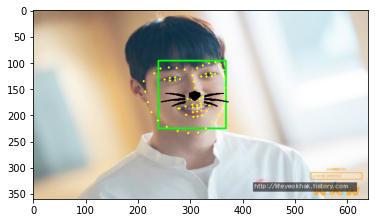

In [27]:
# 구해준 좌표에 스티커를 적용합니다.
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# 스티커는 검은 영역이 0으로 설정되어 있으므로, 스티커가 0인 부분에는 스티커를 표시하고, 아닌 부분에는 표시하지 않는다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

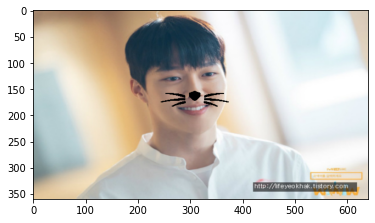

In [28]:
# 초록색 박스와 노란 점이 없는 깨끗한 원본 이미지에 스티커를 붙여줍니다.
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

* 문제 제기   
기울어진 얼굴 각도에 따라 스티커도 기울여 자연스럽게 붙이면 좋겠습니다. 어떻게 하면 될까요?

In [29]:
# 얼굴이 기울어진 각도에 따라 스티커이미지를 회전시키기 위해 함수를 정의합니다.
# opencv의 affine transformation을 활용합니다.

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1],
            flags=cv2.INTER_LINEAR, borderValue=(255,255,255))  # 이미지를 회전하고, 배경은 흰색으로 합니다.
  return result

# 두 점 사이의 각을 구하는 함수를 정의합니다.
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

얼굴이 기울어진 각도: 16.093235900724647


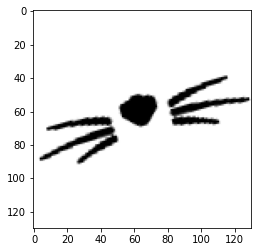

In [30]:
# face landmark의 19, 24번째 점들 사이의 각도를 계산해줍니다.
# face landmark의 최상단 점들(19, 24번째 점)은 얼굴이 기울어져 있으면 기울어진 각만큼 떨어져있습니다.

angle = angle_between(list_points[19], list_points[24]) + 10  # 기울어진 정도에 오차가 있어 오차를 더해줍니다.
print("얼굴이 기울어진 각도:", angle)

# 스티커 이미지를 rotate_image 함수로 기울여줍니다.
img_sticker = rotate_image(img_sticker, angle)
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

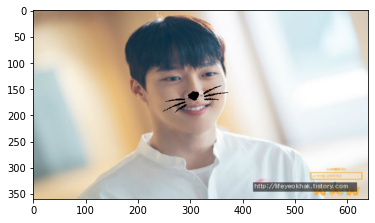

In [31]:
# 초록색 박스와 노란 점이 없는 깨끗한 원본 이미지에 스티커를 붙여줍니다.
sticker_area = img_bgr2[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr2[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

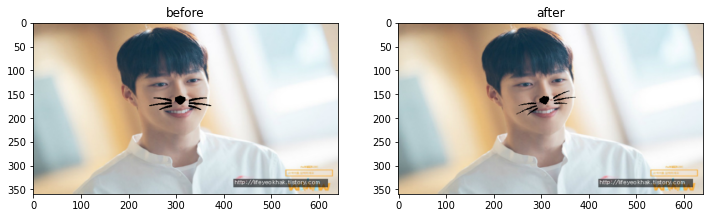

In [32]:
# 기울이기 전과 후를 비교해봅니다.

fig = plt.figure(figsize=(12,24))

plt.subplot(1,2,1)
plt.title("before")
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.title("after")
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

**오른쪽 고양이 수염이 좀 더 얼굴 각도에 자연스럽게 붙어있네요.**

### 3-3) 다양한 사진에 스티커 붙이기 2번

- 얼굴 두개에 스티커 붙이기
- 누워있는 얼굴에 스티커 붙이기

In [33]:
# 다른 이미지 데이터를 준비합니다.
my_img_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_5.jpeg'
img_bgr = cv2.imread(my_img_path)
img_bgr = cv2.resize(img_bgr, (640,360))    # 640*360(16:9) 크기로 resize 합니다.
img_show = img_bgr.copy()    # 출력용 이미지를 별도로 만들어둡니다.

In [34]:
# face detection: 얼굴 영역을 찾아줍니다.
detector_hog = dlib.get_frontal_face_detector()   # dlib을 활용해 detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # openCV의 bgr 이미지를 rgb로 변환
dlib_rects = detector_hog(img_rgb, 1)   # dlib detector는 dlib.rectangles 타입의 객체 반환

rectangles[[(81, 133) (236, 288)], [(366, 98) (551, 284)]]


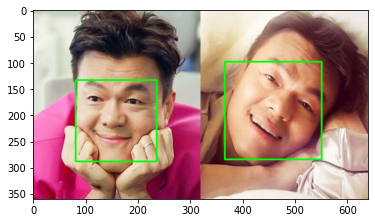

In [35]:
# 찾은 얼굴영역의 좌표를 활용해 초록 박스로 나타냅니다.
# 얼굴이 두 개 있어서 직사각형 영역이 두개가 나타납니다.

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [36]:
# dlib의 모델을 활용해서 face landmark 좌표를 리스트로 만들어줍니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print("첫번째 face landmark 점의 개수는: ", len(list_landmarks[0]))
print("두번째 face landmark 점의 개수는: ", len(list_landmarks[1]))

첫번째 face landmark 점의 개수는:  68
두번째 face landmark 점의 개수는:  68


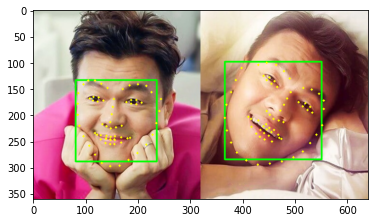

In [37]:
# list_landmarks 에서 좌표를 하나하나 가져와서 점을 찍어줍니다.
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [38]:
# 스티커를 붙이기 위해 필요한 좌표, 너비, 높이를 계산합니다.
# 볼 위치에 고양이 수염이 적용되도록 합니다.

# 고양이 수염의 위치는 x = x(cheek) + {x(nose)-x(cheek)}//2,
# y = y(cheek) + {y(eye) - y(mouth)}//2,
# 스티커 크기는 width = height

# 각각의 얼굴 영역에 필요한 값들을 리스트로 모아줍니다.
list_x = []
list_y = []
list_w = []
list_h = []

for dlib_rect, landmark, i in zip(dlib_rects, list_landmarks, range(2)):
    print('* {}번째 사각형에 대해 *\n'.format(i+1), '턱의 좌표:\n',landmark[2])

    x = landmark[2][0] + (landmark[30][0] - landmark[2][0]) // 2
    y = landmark[2][1] + (landmark[36][1] - landmark[48][1]) // 2
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    list_x.append(x)
    list_y.append(y)
    list_w.append(w)
    list_h.append(h)
    
    print('볼의 x좌표는 코와 턱 중간, y좌표는 눈과 얼굴 좌표의 중간\n (x,y) : (%d,%d)'%(x,y))
    print('스티커 너비와 높이는 구해준 정사각형 얼굴영역의 한변 길이\n (w,h) : (%d,%d)\n\n'%(w,h))
    
print("list_x:" , list_x)
print("list_y:" , list_y)
print("list_w:" , list_w)
print("list_h:" , list_h)

* 1번째 사각형에 대해 *
 턱의 좌표:
 (85, 199)
볼의 x좌표는 코와 턱 중간, y좌표는 눈과 얼굴 좌표의 중간
 (x,y) : (116,166)
스티커 너비와 높이는 구해준 정사각형 얼굴영역의 한변 길이
 (w,h) : (156,156)


* 2번째 사각형에 대해 *
 턱의 좌표:
 (378, 156)
볼의 x좌표는 코와 턱 중간, y좌표는 눈과 얼굴 좌표의 중간
 (x,y) : (425,117)
스티커 너비와 높이는 구해준 정사각형 얼굴영역의 한변 길이
 (w,h) : (186,186)


list_x: [116, 425]
list_y: [166, 117]
list_w: [156, 186]
list_h: [156, 186]


1번째 스티커사진의 모양: (156, 156, 3)
2번째 스티커사진의 모양: (186, 186, 3)


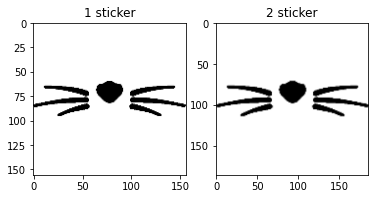

In [39]:
# 스티커 사진을 가져옵니다.
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)  # openCV 로 이미지 읽기

list_img_sticker=[]

for i in range(2):
    img_sticker = cv2.resize(img_sticker, (list_w[i],list_h[i]))  # 위에서 정해준 너비와 높이로 resize
    list_img_sticker.append(img_sticker)
    print('{}번째 스티커사진의 모양:'.format(i+1), img_sticker.shape)
    
    plt.subplot(1, 2, i+1)
    plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
    plt.title('{} sticker'.format(i+1))
    
plt.show()

In [40]:
# 고양이 수염 스티커는 볼에 붙이면 됩니다.
# 스티커 이미지의 시작점인 왼쪽-위 좌표를 찾아줍니다. 볼에서 왼쪽, 위쪽으로 움직여줘야 합니다.

list_refined_x=[]
list_refined_y=[]

for i in range(2):
    refined_x = list_x[i] - list_w[i] // 4   # x좌표를 왼쪽으로 이동
    refined_y = list_y[i] - list_h[i] // 5   # y좌표를 위쪽으로 이동
    
    print('아까 구해준 x,y 좌표를 이미지의 시작점인 왼쪽-위 좌표로 변경해준다.\n',
       '(x,y) : (%d,%d)'%(refined_x,refined_y))
    
    list_refined_x.append(refined_x)
    list_refined_y.append(refined_y)

아까 구해준 x,y 좌표를 이미지의 시작점인 왼쪽-위 좌표로 변경해준다.
 (x,y) : (77,135)
아까 구해준 x,y 좌표를 이미지의 시작점인 왼쪽-위 좌표로 변경해준다.
 (x,y) : (379,80)


기울어진 정도: 323.80967122672104
(186, 186, 3)


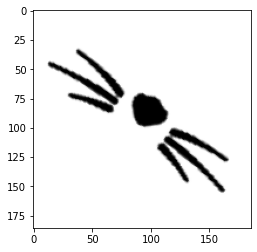

In [41]:
# 두번째 얼굴이 많이 기울어져 있으니, 두번째 얼굴 스티커만 회전해주겠습니다.

# face landmark에서 얼굴 양옆 점들(0번째, 16번재 점)이 이루는 각도를 계산해줍니다.
# face landmark의 얼굴 양옆 점들(0, 16번째 점)은 얼굴이 기울어져 있으면 기울어진 각만큼 떨어져있습니다.

angle = angle_between(list_points[0], list_points[16]) - 30  # 기울어진 각도에 오차를 조정해줍니다.
print("기울어진 정도:",angle)

# 스티커 이미지를 rotate_image 함수로 기울여줍니다.
img_sticker_r = rotate_image(list_img_sticker[1], angle)
print(img_sticker_r.shape)
plt.imshow(cv2.cvtColor(img_sticker_r, cv2.COLOR_BGR2RGB))
plt.show()

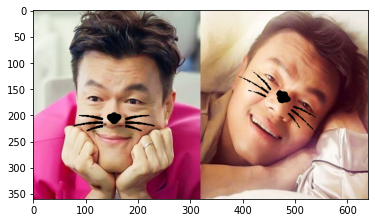

In [42]:
# 초록색 박스와 노란 점이 없는 깨끗한 원본 이미지에 스티커를 붙여줍니다.

# 첫 번째 얼굴에 스티커를 붙입니다.
sticker_area = img_bgr[list_refined_y[0]:list_refined_y[0]+list_img_sticker[0].shape[0],
                           list_refined_x[0]:list_refined_x[0]+list_img_sticker[0].shape[1]]
img_bgr[list_refined_y[0]:list_refined_y[0]+list_img_sticker[0].shape[0],
                list_refined_x[0]:list_refined_x[0]+list_img_sticker[0].shape[1]] = \
    np.where(list_img_sticker[0]==0,list_img_sticker[0],sticker_area).astype(np.uint8)

# 두 번째 얼굴에 스티커를 붙입니다.
sticker_area = img_bgr[list_refined_y[1]:list_refined_y[1]+img_sticker_r.shape[0],
                           list_refined_x[1]:list_refined_x[1]+img_sticker_r.shape[1]]
img_bgr[list_refined_y[1]:list_refined_y[1]+img_sticker_r.shape[0],
                list_refined_x[1]:list_refined_x[1]+img_sticker_r.shape[1]] = \
    np.where(img_sticker_r==0,img_sticker_r,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

**2개의 얼굴에 스티커를 붙이는 것**
- 사각형이 두개 생기니 얼굴 하나일 때 했던 작업(변수생성)을 모두 리스트로 만들어주어야 하는 불편함이 있었습니다. 이것들을 하드코딩하면서, 한번에 처리할 수 있는 방법이 뭐가 있을 지 궁금해졌습니다.

**스티커를 회전시키는 것**
- 먼저 했던 방식으로 두 점 사이의 각을 구해서 회전시키는 방법은 잘 통하지 않았습니다. 오차가 생겨서 이것 또한 상황에 따라 조금씩 해결해주어야 했습니다. 어떤 얼굴이든 스티커가 찰떡으로 붙게하는 방법은 아직 모르겠습니다.

<a id='4'></a>

## 4. 회고
<총평>
- SNOW 사진앱을 사용하면서 얼굴에 다양한 스티커나 필터를 적용하는 것이 어떻게 구현 가능한지 깨닫는 실습이었습니다. 
- 스티커 앱 실행 속도는 빠를수록 좋을 것 같습니다. 실시간으로 촬영하면서 얼굴에 스티커를 확인한다면 더 즐거운 경험이 되니까요! 그리고 정확도 면에서는, 매우 정확하지는 않아도 될 것 같습니다. 물론 스티커가 아무데나 붙어있으면 스티커앱 사용자의 경험이 즐겁지 않겠지만, 10% 내 오차라면 스티커가 재미있게 붙여졌다고 생각할 것 같습니다.
    
<세부 내용>
- 얼굴 영역을 detect 하는 것은 이미 만들어진 dlib 패키지에서 HOG detector 로 가능했으며, 얼굴영역의 face landmarks 68개를 찾는 것 또한 dlib 패키지를 통해 가능했습니다.
- 얼굴 영역과 점들을 찾아줬다면, 스티커를 원하는 위치에 붙여야 하는데 이때 좌표를 구하는 것이 중요했습니다.
- 뿐만 아니라 얼굴이 기울어져 있다면 스티커를 기울여서 붙여줘야 합니다. opencv의 warpAffine으로 affine transformation을 하면 스티커 이미지를 회전할 수 있습니다. 하지만 얼굴이 기울어진 정도를 구해야 하는데, 기울어진 정도를 구하는 것이 오차가 생겨서 모든 얼굴에 적용할만한 알고리즘을 찾지 못했습니다.
- 마지막으로, 얼굴 영역이 2개 이상 검출된다면, 각 영역에 대해 스티커를 각각 붙여줘야 해서 좌표 또한 각각 구해줘야 합니다. 이 과정을 저는 hard coding 했지만 더 좋은 방법이 있을 것이라고 생각됩니다.